# How to Realize a World-Class Data Science Solution?

- On the Importance of Data Preparation - Getting Ready for something Great
- Contextual Data Exploration - How to Identify & Generate Business Value
- <b>Technical Dataset Exploration - Finding the Best Way of Building a Model</b>
- What You Ever Wanted to Know about Model Tuning
- Unsupervised Methods in a Business Context - Time for Great Stories
- Data is Becoming Big - How to Make Your Solution Efficient?
- Operationalizing Your Data Science Solution - DevOps, GDPR & IT Sec.
- Working Models, Stakeholder Management, and Steering of Data Science Projects.

# Part III: Technical Dataset Exploration - Finding the Best Way of Building a Model
Dr. Emanuel Christner<br>
Oct 8, 2018

## Introduction
A typical pitfall I'm seeing when working with fresh Junior Data Scientists or students is application of overcomplex modeling approaches for prediction problems - without taking into consideration characteristics of a dataset. This, in turn, often limits performance of trained models although following well-established receipts for cross-validation, regularization, feature selection, hyper parameter tuning, ...

Imagine for instance a Kaggle Machine Learning competition. In my experience, it is relatively easy to reach top-30% of a leaderboard by simply ensembling some diverse e.g. gradient-boosted models and shallow neural networks. But even extensive model tuning won't help to improve much further. So what the top-guys typically are doing is obtaining a deep understanding of data structure allowing later on very efficient data preparation, feature engineering, and model setup (e.g. balancing data, building separate models for different data clusters, aggregating or removing redundant or noisy features...).

Below you'll find an example how such technical dataset exploration could look like.  We'll use the publicly accessible WDBC dataset for this exercise (medical context, 30 abstract features, binary target label, data already cleaned).


Looking forward to your feedback and ideas for alternate approaches!
## Objectives:
- Technical exploration of WDBC dataset.
- Build a classification model that is able to predict the binary WDBC target variable.

In [1]:
# Import libraries
# linear algebra
import numpy as np
# data processing
import pandas as pd
# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# pca
from sklearn.decomposition import PCA
# dataset splitting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Read dataset
dataset_df=pd.read_csv('WDBC.csv')

## Step 1: Get First Impression about Variables

In [2]:
dataset_df.shape

(569, 32)

In [3]:
dataset_df.head()

,ID,Dep Flag,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
dataset_df.dtypes

ID              int64
Dep Flag       object
Feature_1     float64
Feature_2     float64
Feature_3     float64
Feature_4     float64
Feature_5     float64
Feature_6     float64
Feature_7     float64
Feature_8     float64
Feature_9     float64
Feature_10    float64
Feature_11    float64
Feature_12    float64
Feature_13    float64
Feature_14    float64
Feature_15    float64
Feature_16    float64
Feature_17    float64
Feature_18    float64
Feature_19    float64
Feature_20    float64
Feature_21    float64
Feature_22    float64
Feature_23    float64
Feature_24    float64
Feature_25    float64
Feature_26    float64
Feature_27    float64
Feature_28    float64
Feature_29    float64
Feature_30    float64
dtype: object

In [5]:
# separate id, features, and target
# id
id = dataset_df['ID']

# target, replace: B->0; M->1
target = dataset_df['Dep Flag'].copy()
target.replace({"B": 0, "M": 1}, inplace=True)

# features
features_df = dataset_df[dataset_df.columns.drop(['ID', 'Dep Flag'])]
np.where(id.duplicated() == True) #no duplicate ids
np.where(features_df.duplicated() == True) #no duplicate feature rows

(array([], dtype=int64),)

The dataset consists of an ID column, a binary target variable (which we want to predict), and 30 numeric features. Let's see which of those are useful for our prediction model.

## Step 2: Check for Missing Values and Outliers and Do some Basic Visualizations 

### Simple statistics

In [6]:
features_df.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


No obvious outliers. No missing values. (All values >=0). So we don't need any value imputation in this case.

### Data Normalization

First of all, let's normalize our features. This will help interpreting/comparing numbers and visualizations and we'll have data in the right form for e.g. PCA and logistic regression.

In [7]:
#normalize features
features_scal_df = ((features_df - np.mean(features_df)) / 
                    np.std(features_df))

### Visual Inspection of Feature Distributions

Remark: Set show_all=True to visualize results for all features.

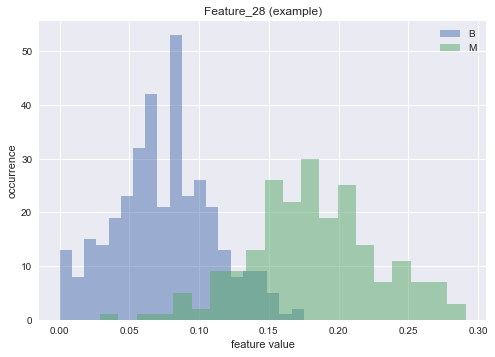

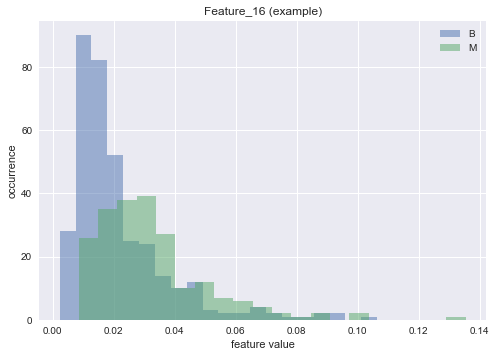

In [8]:
# Visualize distributions
show_all = False # change to 'True' to plot all features
if show_all == True:
    for col in features_df.columns.values:
        plt.figure()
        plt.hist(features_df[col][target == 0], 20, alpha=0.5)
        plt.hist(features_df[col][target == 1], 20, alpha=0.5)
        plt.title(col)
        plt.legend(['B', 'M'])
        plt.xlabel('feature value')
        plt.ylabel('occurrence')    
        plt.show()
else:
        plt.figure()
        plt.hist(features_df['Feature_28'][target == 0], 20, alpha=0.5)
        plt.hist(features_df['Feature_28'][target == 1], 20, alpha=0.5)
        plt.title('Feature_28 (example)')
        plt.legend(['B', 'M'])
        plt.xlabel('feature value')
        plt.ylabel('occurrence')    
        plt.show()
        
        plt.figure()
        plt.hist(features_df['Feature_16'][target == 0], 20, alpha=0.5)
        plt.hist(features_df['Feature_16'][target == 1], 20, alpha=0.5)
        plt.title('Feature_16 (example)')
        plt.legend(['B', 'M'])
        plt.xlabel('feature value')
        plt.ylabel('occurrence')    
        plt.show()        

Many of the features are closely related to the target label (e.g. Feature_28). Higher feature values typically correspond to class M. Because of this strong relation between target and even single features, it should be possible to predict the target with high accuracy.

The histograms for the different features confirm that there are no clear outliers. A few data points with particularly high values (e.g. Feature_16 around 0.13) could be checked more carefully, if some technical information with respect to the features was provided. However, those few data points are no problem for training/evaluating a model.

### Ruling Out a Relation between Feature Values with ID/index

Always good to check relation between feature values and index. In some cases this helps identifying temporal sampling issues, which can e.g. results in over-confident models.

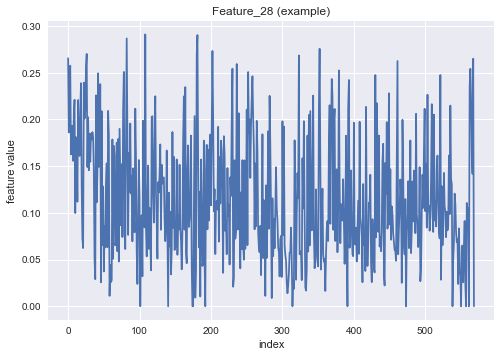

In [9]:
# Check feature-index relation
show_all = False
if show_all == True:
    for col in features_df.columns.values:
        plt.figure()
        plt.plot(features_df[col])
        plt.title(col)
        plt.xlabel('index')
        plt.ylabel('feature value')    
        plt.show()
else:
        plt.figure()
        plt.plot(features_df['Feature_28'])
        plt.title('Feature_28 (example)')
        plt.xlabel('index')
        plt.ylabel('feature value')    
        plt.show()

Some of the features show slightly higher values for index 0..50. However, there is no clear overall relation between feature values and index.

## Step 3: Feature-Target and Feature-Feature relations

### Choosing a Metric

In [10]:
print ('M/(M+B) =', "{0:.2f}".format(sum(target)/len(target)))

M/(M+B) = 0.37


The target is not very unbalanced. For this purely technical reason, I'm going to use accuracy rate or misclassification rate = (1 - accuracy rate) as metric for model selection and evaluation in this excercise.

In practice, the metric will take into account also the context of an analysis. For this WDBC dataset, for instance, it could make sense to optimize on recall or precision given the medical context of the data.

### Simple Naive Baseline Model

In [11]:
baseline = accuracy_score(target, np.zeros(target.shape))
print ('Accuracy rate if all predictions are B:',
       "{0:.2f}".format(baseline), "(=B/(M+B))")

Accuracy rate if all predictions are B: 0.63 (=B/(M+B))


Because 63% of the target corresponds to class B, the accuracy rate is 0.63 if predicting/guessing B for all samples. A predictive model should do much better than this baseline.

### Feature-Target Relations

Create a logistic regression model for each feature to understand how closely each feature is related to the target.

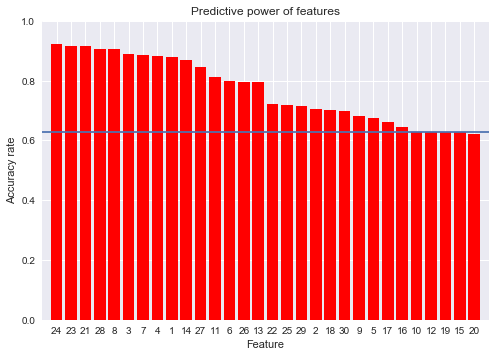

blue line: baseline
Feature_24, accuracy rate: 0.92
Feature_24, misclassification rate: 0.08


In [12]:
# feature-target-relations for all features
# train logistic regression models for each feature
model_logreg_1 = LogisticRegression()
accuracy_rate = []
for col in features_scal_df.columns.values:
    model_logreg_1.fit(features_scal_df[col].to_frame(), target)
    pred_train = model_logreg_1.predict(features_scal_df[col].to_frame())
    accuracy_rate.append(accuracy_score(pred_train, target))

# sort features according to respective accuracy rate of prediction   
indices = np.argsort(accuracy_rate)[::-1]

# plot accuracy rates for features
plt.figure()
plt.title("Predictive power of features")
plt.bar(range(features_scal_df.shape[1]), np.array(accuracy_rate)[indices],
       color="r", align="center")
plt.plot([-1, 30], [baseline, baseline])
plt.xticks(range(features_scal_df.shape[1]), indices+1)
plt.xlim([-1, features_scal_df.shape[1]])
plt.ylim([0, 1])
plt.xlabel('Feature')
plt.ylabel('Accuracy rate')
plt.show()
print ('blue line: baseline')

print ('Feature_24, accuracy rate:', "{0:.2f}".format(accuracy_rate[23]))
print ('Feature_24, misclassification rate:', "{0:.2f}".format(
    1-accuracy_rate[23]))

Figure above shows accuracy rates of the 30 logistic regression models - each of them trained with one single feature. Some very strong features allow efficiently predicting the target class (e.g. Feature_24: misclassification rate=0.08; training error - no CV).

### Feature-Feature Relations

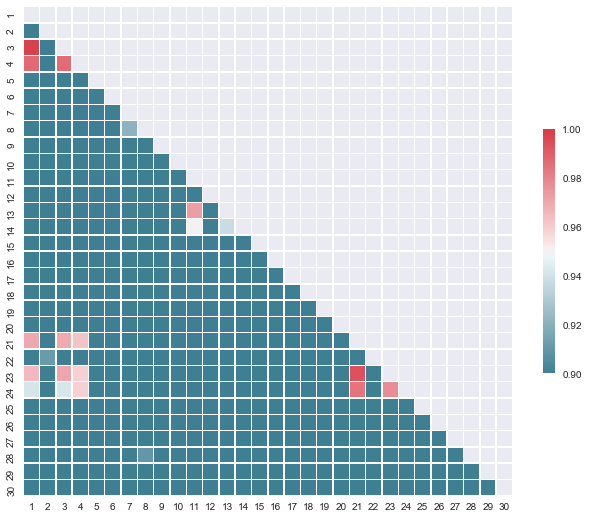

In [13]:
# feature-feature-relations
# correlation matrix
correlation_matrix = features_df.corr().values

#mask
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#plot
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=0.9,
            #min=0.9 chosen because no strong negative correlation
            #between features in this daaset
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(np.array(range(0,30))+0.5, range(1,31))
plt.yticks(np.array(range(0,30))+0.5, range(30,0,-1))
plt.show()


Some of the features are strongly correlated (R>0.99): 1,3; 1,4; 21,23; 21,24. Let's visualize them:

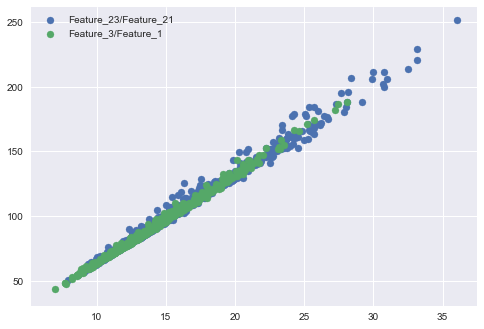

In [14]:
# Visualize correlated features I (1,3; 21,23)
plt.figure()
plt.scatter(features_df['Feature_21'], features_df['Feature_23'])
plt.scatter(features_df['Feature_1'], features_df['Feature_3'])
plt.legend(['Feature_23/Feature_21', 'Feature_3/Feature_1'])
plt.show()
# np.corrcoef(features_df['Feature_21'], features_df['Feature_23'])[0][1]
# R=0.9937
# np.corrcoef(features_df['Feature_1'], features_df['Feature_3'])[0][1]
# R=0.9979

Feature_1 is closely linearly related to Feature_3. Feature_3 could reflect measurements from an additional sensor or an imprecise linear transformation of Feature_1.

Also, Feature_21 and Feature_23 show an almost identical linear relation with same slope as found for Feature_3 and Feature_1. This points to a transformation rather than to redundant measurements. Slight scatter implies that this transformation involves some uncertainty.

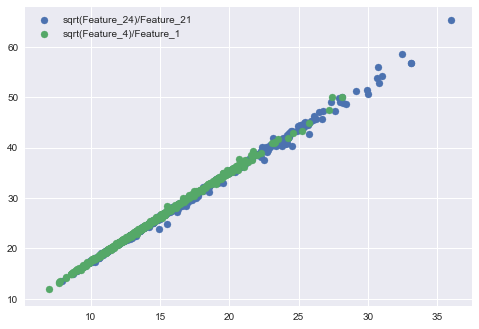

In [15]:
# Visualize correlated features II (1,4; 21,24)
plt.figure()
plt.scatter(features_df['Feature_21'], np.sqrt(features_df['Feature_24']))
plt.scatter(features_df['Feature_1'], np.sqrt(features_df['Feature_4']))
plt.legend(['sqrt(Feature_24)/Feature_21', 'sqrt(Feature_4)/Feature_1'])
plt.show()
# np.corrcoef(features_df['Feature_21'],np.sqrt(features_df['Feature_24']))[0][1]
# R=0.9988
# np.corrcoef(features_df['Feature_1'],np.sqrt(features_df['Feature_4']))[0][1]
# R=0.9994

Feature_1 is closely quadratically related to Feature_4 (note: Fig. shows square root for Feature_4 and Feature_24).

Feature_21 and Feature_24 show an almost identical quadratic relation as Feature_1 and Feature_4. This again points to computed features.

### Remove Redundant Features

Redundant features bear a risk of deteriorating model performance. To reduce redundancy, I'm going to combine the linearly related features: Feature_1,Feature_3 and Feature_21,Feature_23.

For the moment, I'll keep the quadratic features (maybe they were intentionally included as higher-order terms for logistic regression). 

In [16]:
# combine strongly correlated features: (1) linear transformation, then (2) averaging
# linear model for f1,f3
model_linreg_1 = LinearRegression()
model_linreg_1.fit(features_scal_df['Feature_1'].to_frame(),
        features_scal_df['Feature_3'].to_frame())
model_linreg_1.coef_#6.88040029
model_linreg_1.intercept_#-5.23238879

# linear model for f21,f23
model_linreg_2 = LinearRegression()
model_linreg_2.fit(features_scal_df['Feature_21'].to_frame(),
        features_scal_df['Feature_23'].to_frame())
model_linreg_2.coef_#6.90863713
model_linreg_2.intercept_#-5.13671616

# use averages as new features
features_scal_df['Feature_31'] = (0.5 * features_scal_df['Feature_3'].
        to_frame() + 0.5 * model_linreg_1.predict(
        features_scal_df['Feature_1'].to_frame()))
features_scal_df['Feature_32'] = (0.5 * features_scal_df['Feature_23'].
        to_frame() + 0.5 * model_linreg_2.predict(
        features_scal_df['Feature_21'].to_frame()))

# drop old features
features_scal_df.drop(['Feature_1', 'Feature_3',
        'Feature_21', 'Feature_23'], axis=1, inplace=True)

## Step 4: Quick Impression on Overall Structure of the Dataset

A nice way of getting a first qualitative impression on the overall data structure (clusters, noise) is unsupervised clustering. A very quick alternate approach, which I'll use here, is projecting the features onto two easy-to-visualize principal components.

### PCA: Project Data onto Principal Components

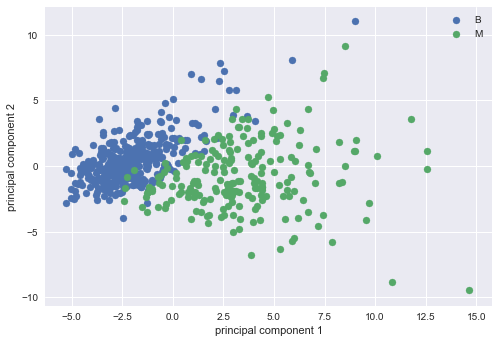

In [17]:
# principal component decomposition
pcan = PCA(n_components=2)
pcan.fit(features_scal_df)
comp = pcan.transform(features_scal_df)

#plot
ind_B=np.where(target == 0)
ind_M=np.where(target == 1)
plt.figure()
plt.scatter(comp[ind_B, 0], comp[ind_B, 1])
plt.scatter(comp[ind_M, 0], comp[ind_M, 1])
plt.legend(['B', 'M'])
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

The decomposed data is nicely separated into two clusters. A very simple logistic regression model should be able to find a linear decision boundary that efficiently separates both clusters:

In [18]:
# logistic regression model based on the two principal components
# split data into five subsets for cross validation (cv)
kfold = StratifiedKFold(n_splits=5, 
                            random_state=2017, 
                            shuffle=True)    

model_logreg_2 = LogisticRegression(C=10) #C=10: no regularization
cv_single=[];
for i, (ind_train, ind_val) in enumerate(kfold.split(comp, target)):
    X_train, X_val = comp[ind_train, :], comp[ind_val, :]
    y_train, y_val = target[ind_train], target[ind_val]
    # train model
    model_logreg_2.fit(X_train, y_train)
    # predict for validation set
    y_pred = model_logreg_2.predict(X_val)
    # calculate misclassification rate
    cv_single.append(1 - accuracy_score(y_val, y_pred))
print ('Misclassification rate for logistic regression model:',
       "{0:.3f}".format(np.mean(cv_single)), '+-',
       "{0:.3f}".format(np.std(cv_single)), '(5-fold cv)')

Misclassification rate for logistic regression model: 0.051 +- 0.015 (5-fold cv)


The misclassification rate of a logistic regression model trained on the two principal components is 0.051 for unseen data (5-fold cross validation (cv)). The standard deviation between the five folds is 0.015.

## Step 5: Final Model

### Model Selection

Many of the features show a strong relation with the target values (see step 2, step 3).

The highly predictive, linearly separable structure after projection onto two principal components (step 4) implies that non-linearity of features, feature-feature relations, and noise play a minor role for predicting the target label. 

For these reasons, I'm going to use 'simple' logistic regression for the final model. I'll include all features and apply regularization to avoid overfitting.

### Splitting Data into Train, Cross-Validation, and Test Set

I split the data into 5 pieces:<br>
80%: training+cv set.<br>
20%: test set.

In [19]:
# 4:1 (train/cv)-test-split
X_train_cv, X_test, y_train_cv, y_test = train_test_split(features_scal_df, target,
                                                    test_size=0.2,
                                                    random_state=2017,
                                                    stratify=target)
X_train_cv.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train_cv.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Tuning of Regularization Parameter
To tune the model, I use 4-fold cv.

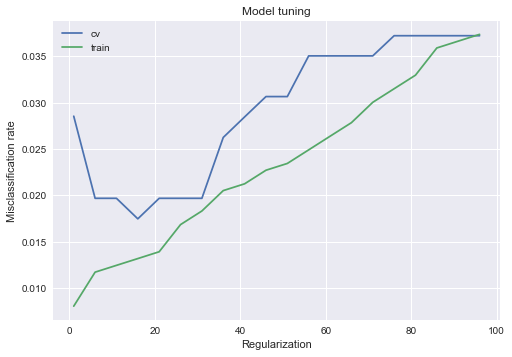

Misclassification rate with 'reg' = 16 :  0.017 +- 0.017 (4-fold cv)


In [20]:
# model tuning
# split data into subsets for cv
kfold = StratifiedKFold(n_splits=4, 
                            random_state=2017, 
                            shuffle=True)    
reg = [] #regularization parameter
cv_all = []
cv_all_std = []
train_all = []
#iterate over different regularization parameters
for c in range(1, 100, 5):
    reg.append(c)    
    reg_inv=1 / reg[-1]
    model_logreg_3 = LogisticRegression(penalty='l2', C=reg_inv)
    cv_single = [];
    train_single = [];
    #4-fold cv
    for i, (ind_train, ind_val) in enumerate(kfold.split(X_train_cv, y_train_cv)):
        X_train, X_val = X_train_cv.loc[ind_train], X_train_cv.loc[ind_val]
        y_train, y_val = y_train_cv[ind_train], y_train_cv[ind_val]
        #train model
        model_logreg_3.fit(X_train, y_train)
        #predict for validation set
        y_pred_val = model_logreg_3.predict(X_val)
        #predict for training set
        y_pred_train = model_logreg_3.predict(X_train)
        #calculate misclassification rates
        cv_single.append(1 - accuracy_score(y_val, y_pred_val))
        train_single.append(1 - accuracy_score(y_train, y_pred_train))
    #calculate mean values from cv-folds    
    cv_all.append(np.mean(cv_single))
    cv_all_std.append(np.std(cv_single))
    train_all.append(np.mean(train_single))

#plot results
plt.title('Model tuning')
plt.figure
plt.plot(reg, cv_all)    
plt.plot(reg, train_all)
plt.legend(['cv', 'train'])
plt.xlabel('Regularization')
plt.ylabel('Misclassification rate')
plt.show()    

#print misclassification rate
print ('Misclassification rate with \'reg\' =', reg[3], ': ', "{0:.3f}".format(cv_all[3]),
       '+-', "{0:.3f}".format(cv_all_std[3]), '(4-fold cv)')

'reg'=0..16: high variance regime<br>
'reg'=16..: high bias regime

I choose a regularization parameter of 'reg'=16 (relatively strong regularization), which reflects an optimal tradeoff between model bias and variance. For this 'reg'=16, the misclassification rate is 0.017 (4-fold cv). The standard deviation of folds is in the same order of magnitude (0.017). Because of the tuning, the misclassification rate derived from cv might be a bit to optimistic. So we'll use the untouched test set for a completely independent validation.

### Training of the Final Model and Validation against Test Set

For training the final model, we use the whole train/cv data and 'reg'=16.

In [21]:
# final model
model_logreg_4 = LogisticRegression(penalty='l2', C=1/16) 
# train with all data from train/cv-set
model_logreg_4.fit(X_train_cv, y_train_cv)
# prediction for unseen test set
y_pred_test = model_logreg_4.predict(X_test)
# print results
print ('Misclasification rate for test set:      ',
       "{0:.3f}".format(1 - accuracy_score(y_test, y_pred_test)),
       '+-', "{0:.3f}".format(cv_all_std[3]), '(+-: std from cv)')
print ("Precision:", "{0:.3f}".format(precision_score(y_test, y_pred_test)))
print ("Recall:", "{0:.3f}".format(recall_score(y_test, y_pred_test)))

Misclasification rate for test set:       0.018 +- 0.017 (+-: std from cv)
Precision: 1.000
Recall: 0.952


### Evaluation of Final Model

The misclassification rate for the untouched test set is 0.018 which is close to the cv-score of 0.017. So the model mispredicts only about 2% of the target data. In other words, accuracy of our model is 98%.

Other performance metrics:<br>
Precision (correctly predicted M)/(all predicted as M) is 1 (all predicted M were really M).<br>
Recall (correctly predicted M)/(all M) is 0.95 (95% of class M were correctly labeled).

# Conclusions

Many of the features in this dataset show an easy-to-capture and strong relation to the target (see step 2, step 3). Non-linearity of features, feature-feature relations, and noise only play a minor role for predicting the target (see step 4).
For these reasons, it is possible to predict the target with a small misclassification rate of about 2% by means of a strongly regularized logistic regression model.


### Possible Strategies for Further Improving the Model

<b>Technical Options:</b><br>
1. There is a lot of redundant information among the different features (see Feature-Feature-Relations in step 3). Stepwise feature selection or PCA could be used to eliminate this redundancy and the degree of freedom of the model. This would allow using weaker regularization, which, in turn, could reduce the model bias for the given model variance.<br>
2. A more complex model (e.g. adding higher-order terms to logistic regression model or gradient boosted trees) could be able to slightly better capture variations around the decision boundary. However, such a model would require even stronger regularization to avoid overfitting.

<b>Requirement: More Data!</b>

Variance of the final model is in the same order of magnitude as the misclassification rate. So judging if a model adjustment according to points 1 or 2 really means an improvement will be challenging. For this reason, more data would be needed first for reducing model variance and for becoming able judging further minor model improvements.

### What We Learned

This technical data set exploration gives an orientation regarding data quality, data distribution, predictive power of individual features, correlation among different features and overall data structure of the WDBC data set.

Based on this information, we have been able to rule out a number of typical pitfalls often deteriorating model performance and  to select a promising easy-to-communicate classification model.

Maybe most importantly, we understand why our model is performing well and what effort (getting more data in this case) would be needed to improve the model further. This provides a valuable basis for estimating costs for further improvements and deciding about next steps.